#Summary

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.



L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

#Import libraries

In [1]:
# import os

# os.chdir('/content/drive/MyDrive/MLOps/Home-credit-default-risk')

In [2]:

%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
import os
import sys
from pathlib import Path

# Add the parent directory to the Python path
sys.path.append(str(Path.cwd().parent))

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import numpy as np
import gc
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import math
import pickle
import zipfile

from src.utils import reduce_memory_usage
from src.load_all_dataset import load_all_dataset
from settings.params import PARAMS

In [3]:
# télécharger les données
load_all_dataset()

2024-08-08 02:34:42.700 | INFO     | src.load_all_dataset:load_all_dataset:27 - Directory created: data/home-credit-default-risk/
2024-08-08 02:34:42.722 | INFO     | src.load_all_dataset:load_all_dataset:35 - Downloading data for into directory: data/home-credit-default-risk/


100%|██████████| 688M/688M [05:31<00:00, 2.18MB/s] 
2024-08-08 02:40:15.258 | INFO     | src.load_all_dataset:load_all_dataset:37 - Download successful.


2024-08-08 02:40:42.984 | INFO     | src.load_all_dataset:load_all_dataset:47 - Files successfully extracted into directory: data/home-credit-default-risk/
2024-08-08 02:40:42.986 | INFO     | src.load_all_dataset:load_all_dataset:54 - Extracted files: ['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'home-credit-default-risk.zip', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [4]:
# Chemin du dossier contenant les fichiers CSV
directory_path = PARAMS['file_directory']

# Lister tous les fichiers CSV dans le dossier
# Lister tous les fichiers CSV dans le dossier
file_list = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
file_list.remove('HomeCredit_columns_description.csv')

# Dictionnaire pour stocker les DataFrames
dataframes = {}

# Lire chaque fichier, appliquer la fonction de réduction de mémoire, et afficher les informations
for file_name in file_list:
    print(f"\nProcessing file: {file_name}")
    file_path = os.path.join(directory_path, file_name)

    # Lire le fichier CSV
    df = pd.read_csv(file_path)

    # Appliquer la fonction de réduction de mémoire
    df = reduce_memory_usage(df)

    # Stocker le DataFrame dans le dictionnaire
    dataframes[file_name] = df

    # Afficher le nombre de data points et de features
    print(f"Number of data points: {df.shape[0]}")
    print(f"Number of features: {df.shape[1]}")

    # Afficher les premières lignes de la table
    print(df.head())


Processing file: application_test.csv


2024-08-08 02:40:43.670 | INFO     | src.utils:reduce_memory_usage:25 - Memory usage of dataframe is 45.00 MB
2024-08-08 02:40:43.781 | INFO     | src.utils:reduce_memory_usage:56 - Memory usage after optimization is: 14.60 MB
2024-08-08 02:40:43.782 | INFO     | src.utils:reduce_memory_usage:57 - Decreased by 67.6%


Number of data points: 48744
Number of features: 121
   SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FL

2024-08-08 02:40:48.757 | INFO     | src.utils:reduce_memory_usage:25 - Memory usage of dataframe is 286.23 MB
2024-08-08 02:40:49.482 | INFO     | src.utils:reduce_memory_usage:56 - Memory usage after optimization is: 92.38 MB
2024-08-08 02:40:49.483 | INFO     | src.utils:reduce_memory_usage:57 - Decreased by 67.7%


Number of data points: 307511
Number of features: 122
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLA

2024-08-08 02:40:52.558 | INFO     | src.utils:reduce_memory_usage:25 - Memory usage of dataframe is 222.62 MB
2024-08-08 02:40:53.008 | INFO     | src.utils:reduce_memory_usage:56 - Memory usage after optimization is: 112.95 MB
2024-08-08 02:40:53.009 | INFO     | src.utils:reduce_memory_usage:57 - Decreased by 49.3%


Number of data points: 1716428
Number of features: 17
   SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0

2024-08-08 02:40:59.152 | INFO     | src.utils:reduce_memory_usage:25 - Memory usage of dataframe is 624.85 MB
2024-08-08 02:40:59.395 | INFO     | src.utils:reduce_memory_usage:56 - Memory usage after optimization is: 338.46 MB
2024-08-08 02:40:59.396 | INFO     | src.utils:reduce_memory_usage:57 - Decreased by 45.8%


Number of data points: 27299925
Number of features: 3
   SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

Processing file: credit_card_balance.csv


2024-08-08 02:41:09.283 | INFO     | src.utils:reduce_memory_usage:25 - Memory usage of dataframe is 673.88 MB
2024-08-08 02:41:10.680 | INFO     | src.utils:reduce_memory_usage:56 - Memory usage after optimization is: 289.33 MB
2024-08-08 02:41:10.681 | INFO     | src.utils:reduce_memory_usage:57 - Decreased by 57.1%


Number of data points: 3840312
Number of features: 23
   SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE    AMT_BALANCE  \
0     2562384      378907              -6      56.970001   
1     2582071      363914              -1   63975.554688   
2     1740877      371185              -7   31815.224609   
3     1389973      337855              -4  236572.109375   
4     1891521      126868              -1  453919.468750   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5  

2024-08-08 02:41:23.746 | INFO     | src.utils:reduce_memory_usage:25 - Memory usage of dataframe is 830.41 MB
2024-08-08 02:41:25.942 | INFO     | src.utils:reduce_memory_usage:56 - Memory usage after optimization is: 311.40 MB
2024-08-08 02:41:25.943 | INFO     | src.utils:reduce_memory_usage:57 - Decreased by 62.5%


Number of data points: 13605401
Number of features: 8
   SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT   AMT_PAYMENT  
0          -1180.0             -1187.0     6948.359863   6948.359863  
1          -2156.0             -2156.0     1716.525024   1716.525024  
2            -63.0               -63.0    25425.000000  25425.000000  
3          -2418.0             -2426.0    24350.130859  24350.130859  
4          -1383.0             -1366.0     2165.040039   2160.584961  

Processing file: POS_CASH_balance.csv


2024-08-08 02:41:34.778 | INFO     | src.utils:reduce_memory_usage:25 - Memory usage of dataframe is 610.43 MB
2024-08-08 02:41:35.673 | INFO     | src.utils:reduce_memory_usage:56 - Memory usage after optimization is: 238.45 MB
2024-08-08 02:41:35.675 | INFO     | src.utils:reduce_memory_usage:57 - Decreased by 60.9%


Number of data points: 10001358
Number of features: 8
   SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0  

Processing file: previous_application.csv


2024-08-08 02:41:43.885 | INFO     | src.utils:reduce_memory_usage:25 - Memory usage of dataframe is 471.48 MB
2024-08-08 02:41:44.672 | INFO     | src.utils:reduce_memory_usage:56 - Memory usage after optimization is: 309.01 MB
2024-08-08 02:41:44.673 | INFO     | src.utils:reduce_memory_usage:57 - Decreased by 34.5%
2024-08-08 02:41:44.710 | INFO     | src.utils:reduce_memory_usage:25 - Memory usage of dataframe is 0.74 MB
2024-08-08 02:41:44.714 | INFO     | src.utils:reduce_memory_usage:56 - Memory usage after optimization is: 0.28 MB
2024-08-08 02:41:44.715 | INFO     | src.utils:reduce_memory_usage:57 - Decreased by 62.5%


Number of data points: 1670214
Number of features: 37
   SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE   AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans   1730.430054          17145.0   
1     2802425      108129         Cash loans  25188.615234         607500.0   
2     2523466      122040         Cash loans  15060.735352         112500.0   
3     2819243      176158         Cash loans  47041.335938         450000.0   
4     1784265      202054         Cash loans  31924.394531         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY 

#EDA on the ‘Application Train’ Dataset:

In [5]:
application_train_df = dataframes['application_train.csv']

Number of customers who will not repay the loan on time: 24825 (8.07%)
Number of customers who will repay the loan on time: 282686 (91.93%)


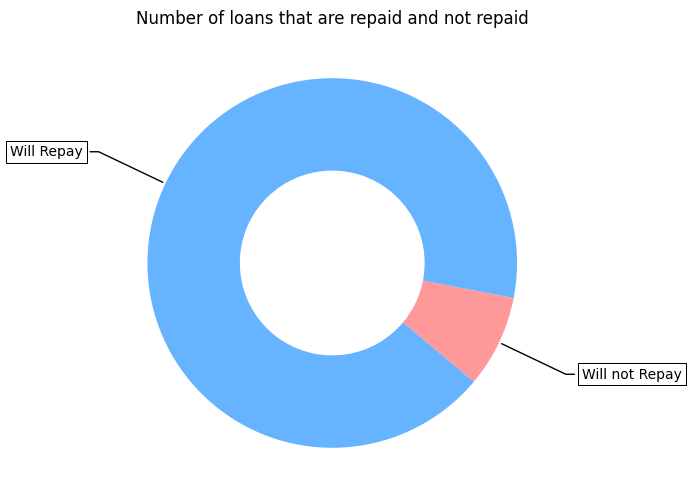

In [6]:
#  chargeons le df DataFrame chargé depuis 'application_train.csv'
train_data = dataframes['application_train.csv']

# Comptage des valeurs de la colonne 'TARGET'
y_value_counts = train_data['TARGET'].value_counts()
n_repaid = y_value_counts[0]
n_not_repaid = y_value_counts[1]

# Afficher les statistiques des classes
print(
    f"Number of customers who will not repay the loan on time: {n_not_repaid} ({(n_not_repaid/(n_repaid+n_not_repaid))*100:.2f}%)"
)
print(
    f"Number of customers who will repay the loan on time: {n_repaid} ({(n_repaid/(n_repaid+n_not_repaid))*100:.2f}%)"
)

# Visualisation des données avec un diagramme circulaire
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
labels = ["Will not Repay", "Will Repay"]
data = [n_not_repaid, n_repaid]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40, colors=["#ff9999", "#66b3ff"])

# Annotations pour les segments du diagramme
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2.0 + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(
        labels[i], xy=(x, y), xytext=(1.35 * np.sign(x), 1.4 * y), horizontalalignment=horizontalalignment, **kw
    )

ax.set_title("Number of loans that are repaid and not repaid")
plt.show()


Analyzing feature: NAME_CONTRACT_TYPE


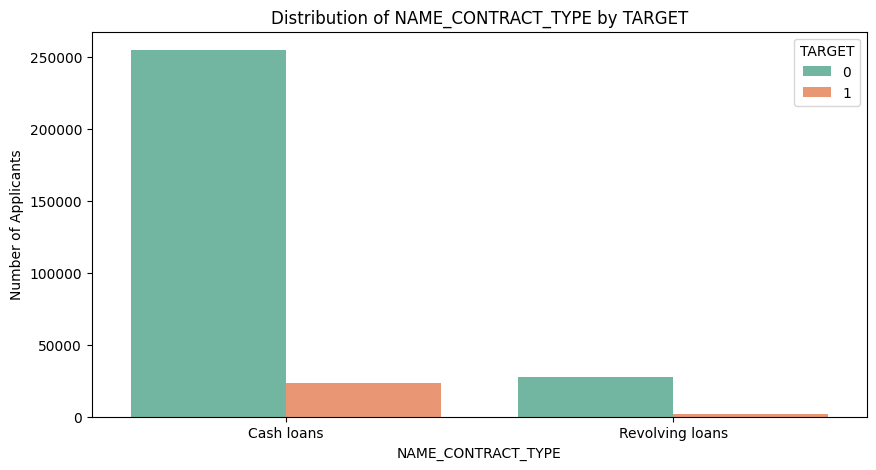


Analyzing feature: CODE_GENDER


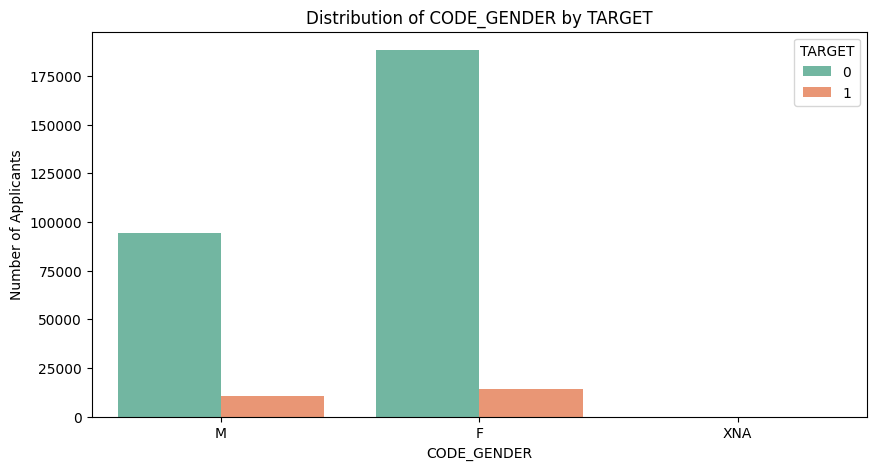


Analyzing feature: FLAG_OWN_CAR


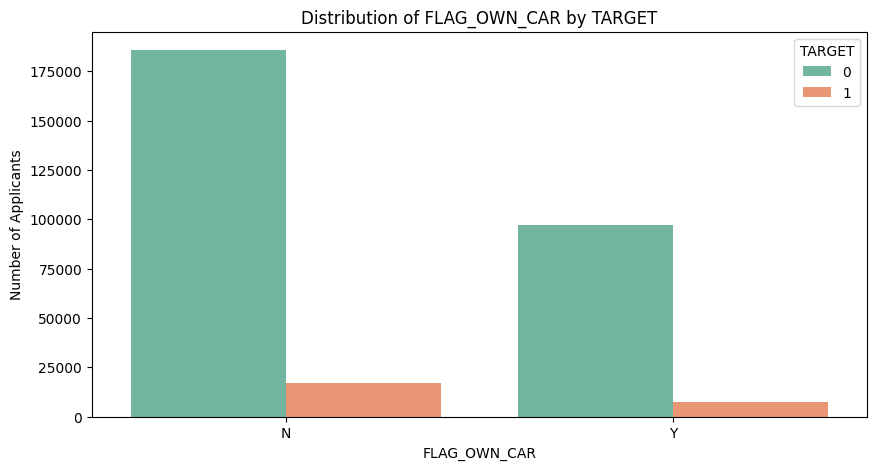


Analyzing feature: FLAG_OWN_REALTY


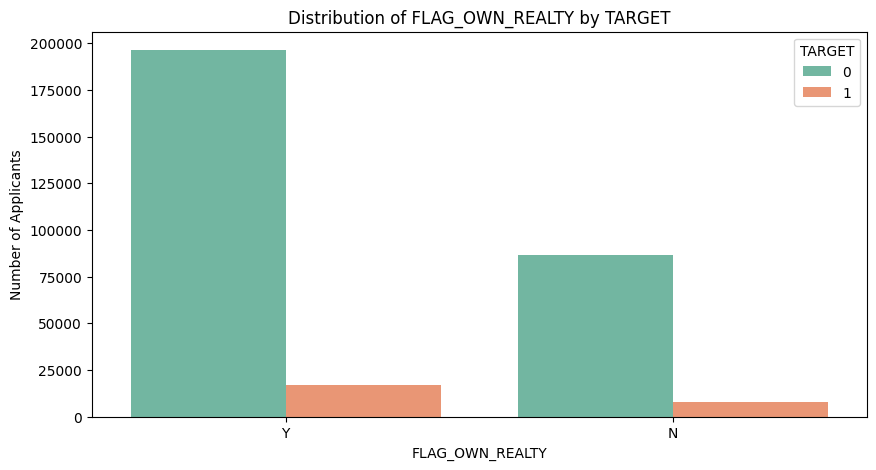

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


def univariate_barplots(df, feature, target='TARGET'):
    """
    This function plots bar charts for categorical features against the target variable.

    Parameters:
    - df: pandas DataFrame containing the data.
    - feature: str, the name of the categorical feature column.
    - target: str, the name of the target column (default is 'TARGET').
    """
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=feature, hue=target, palette='Set2')
    plt.title(f'Distribution of {feature} by {target}')
    plt.ylabel('Number of Applicants')
    plt.xlabel(feature)
    plt.legend(title=target, loc='upper right')
    plt.show()


# Utilisation de la fonction pour analyser les colonnes spécifiées
categorical_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

for feature in categorical_features:
    print(f"\nAnalyzing feature: {feature}")
    univariate_barplots(train_data, feature)


Analyzing feature: CNT_CHILDREN


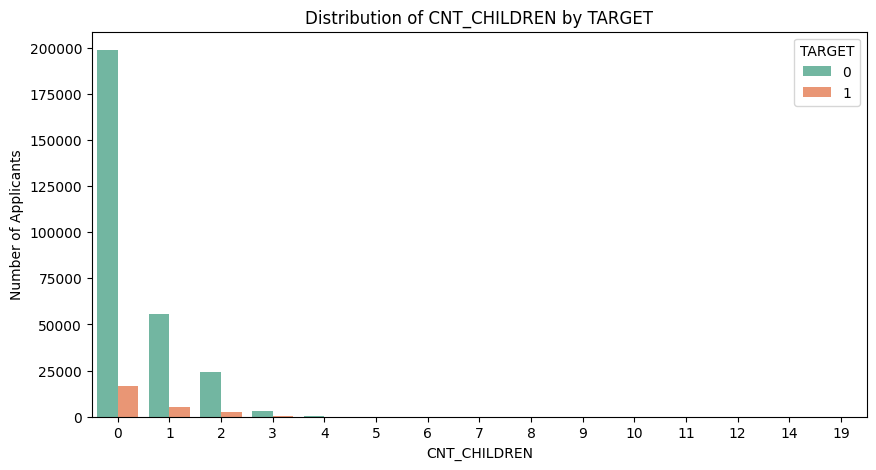


Analyzing feature: NAME_TYPE_SUITE


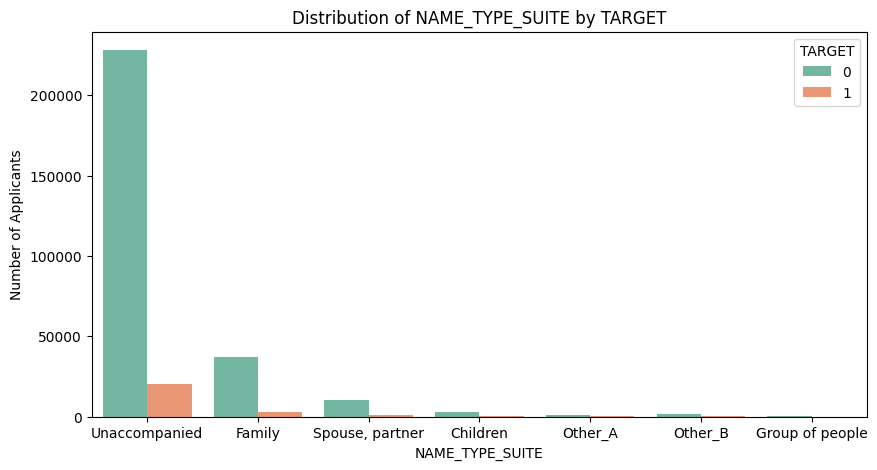


Analyzing feature: NAME_INCOME_TYPE


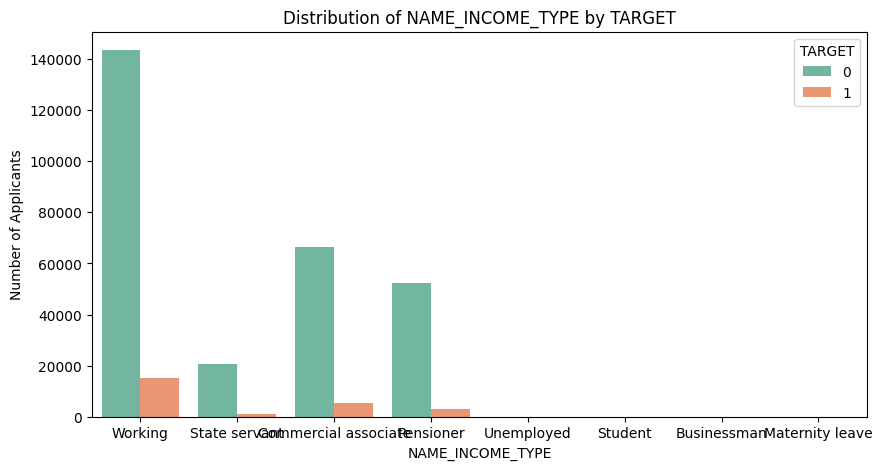


Analyzing feature: NAME_FAMILY_STATUS


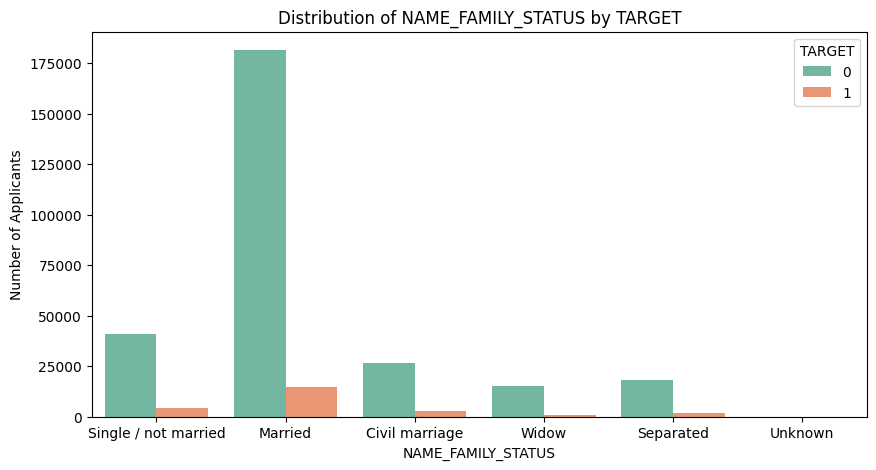

In [8]:
# Utilisation de la fonction pour analyser les colonnes spécifiées
features_to_analyze = ['CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS']

for feature in features_to_analyze:
    print(f"\nAnalyzing feature: {feature}")
    univariate_barplots(train_data, feature)


Analyzing feature: AMT_CREDIT


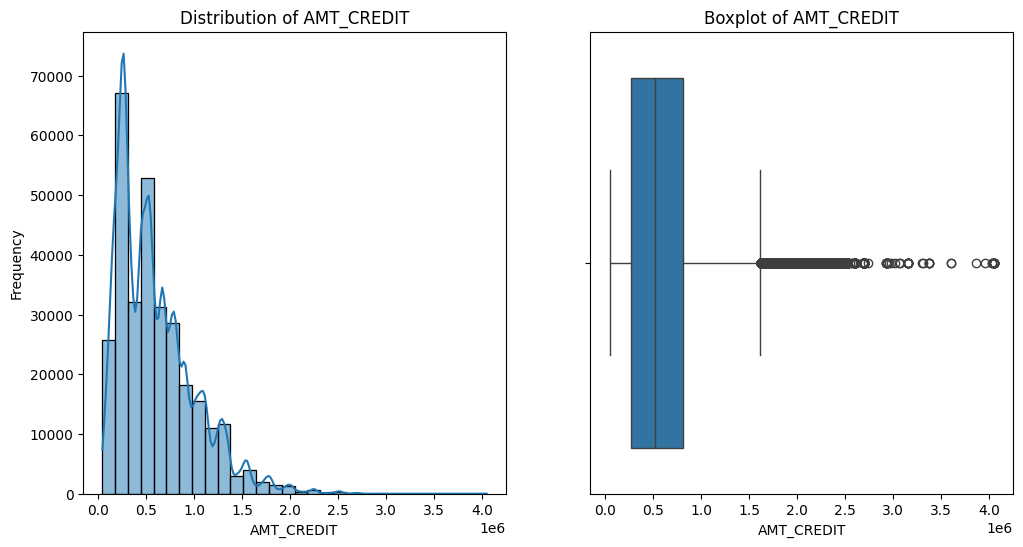


Analyzing feature: AMT_GOODS_PRICE


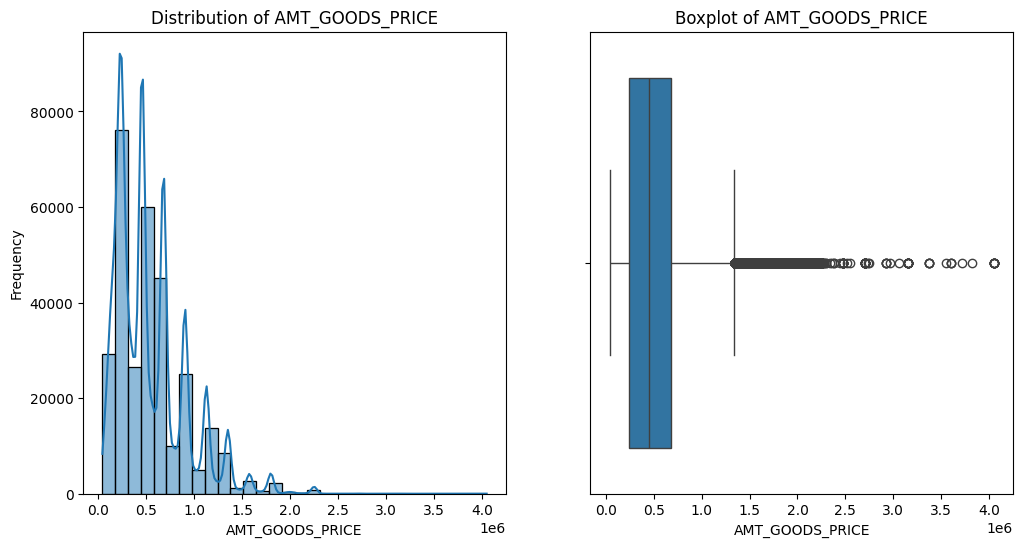


Analyzing feature: AGE_YEARS


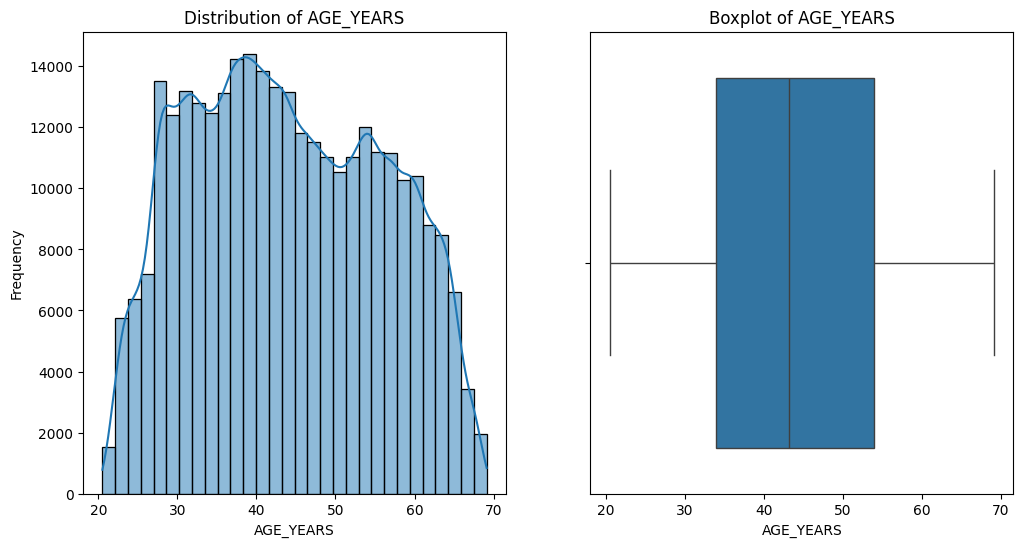

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_numerical_distribution(df, feature, bins=30):
    """
    This function plots histogram and boxplot for numerical features.

    Parameters:
    - df: pandas DataFrame containing the data.
    - feature: str, the name of the numerical feature column.
    - bins: int, the number of bins for the histogram (default is 30).
    """
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], bins=bins, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')

    plt.show()


# Analyse des caractéristiques numériques
numerical_features = ['AMT_CREDIT', 'AMT_GOODS_PRICE', 'DAYS_BIRTH']

# Ajustement de l'âge pour le convertir en années positives
train_data['AGE_YEARS'] = train_data['DAYS_BIRTH'] / -365

# Remplacer 'DAYS_BIRTH' par 'AGE_YEARS' pour l'analyse
numerical_features[-1] = 'AGE_YEARS'

for feature in numerical_features:
    print(f"\nAnalyzing feature: {feature}")
    plot_numerical_distribution(train_data, feature)


Analyzing feature: AMT_CREDIT


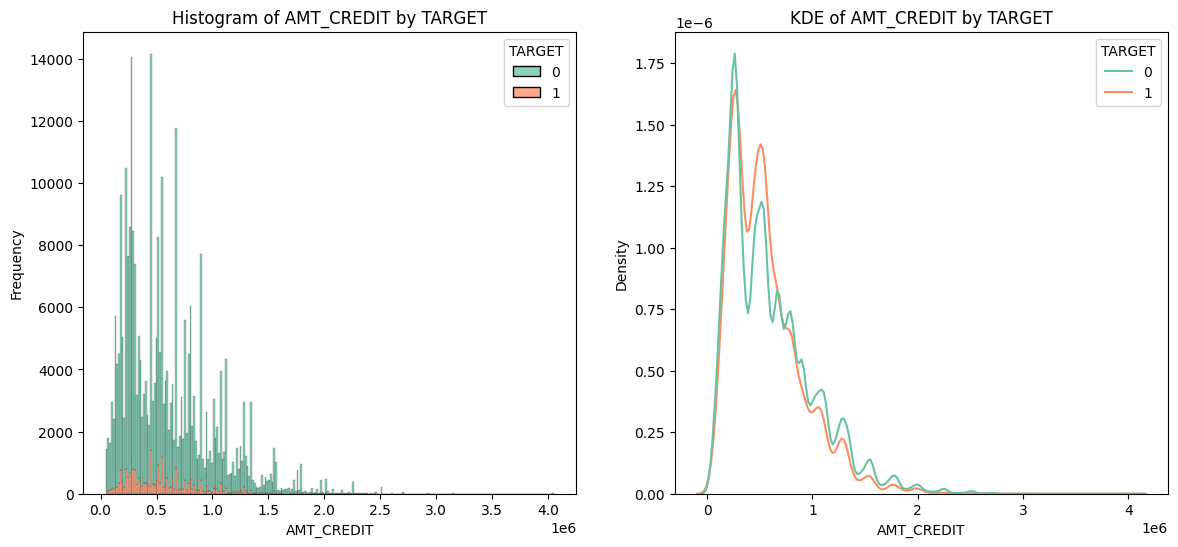


Analyzing feature: AMT_GOODS_PRICE


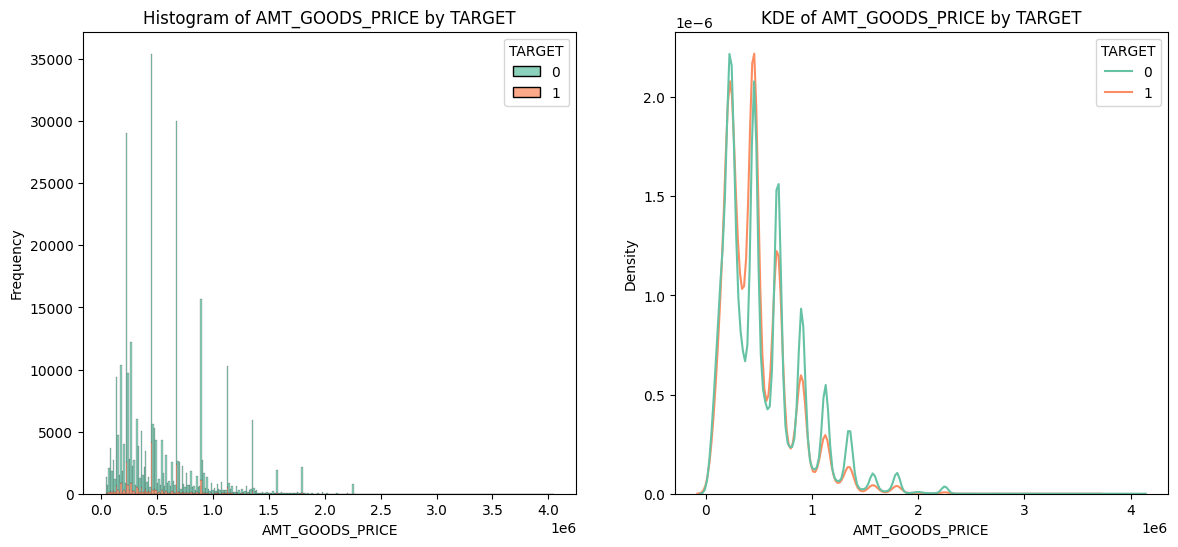


Analyzing feature: AGE_YEARS


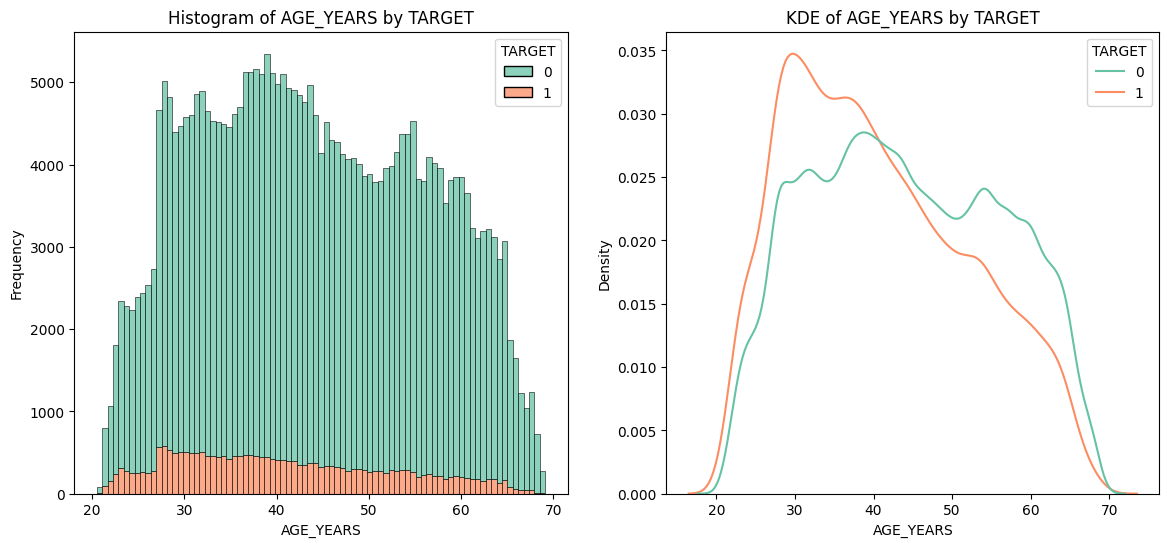

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_numerical_vs_target(df, feature, target='TARGET'):
    """
    This function plots histograms and KDE plots for numerical features
    colored by the target variable.

    Parameters:
    - df: pandas DataFrame containing the data.
    - feature: str, the name of the numerical feature column.
    - target: str, the name of the target column (default is 'TARGET').
    """
    plt.figure(figsize=(14, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=feature, hue=target, multiple="stack", palette='Set2')
    plt.title(f'Histogram of {feature} by {target}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # KDE Plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df, x=feature, hue=target, common_norm=False, palette='Set2')
    plt.title(f'KDE of {feature} by {target}')
    plt.xlabel(feature)
    plt.ylabel('Density')

    plt.show()


# Analyse des caractéristiques numériques en fonction de la variable cible
numerical_features = ['AMT_CREDIT', 'AMT_GOODS_PRICE', 'AGE_YEARS']

for feature in numerical_features:
    print(f"\nAnalyzing feature: {feature}")
    plot_numerical_vs_target(train_data, feature)

In [11]:
def fix_nulls_outliers(data):

    data['NAME_FAMILY_STATUS'].fillna('Data_Not_Available', inplace=True)
    data['NAME_HOUSING_TYPE'].fillna('Data_Not_Available', inplace=True)

    data['FLAG_MOBIL'].fillna('Data_Not_Available', inplace=True)
    data['FLAG_EMP_PHONE'].fillna('Data_Not_Available', inplace=True)
    data['FLAG_CONT_MOBILE'].fillna('Data_Not_Available', inplace=True)
    data['FLAG_EMAIL'].fillna('Data_Not_Available', inplace=True)

    data['OCCUPATION_TYPE'].fillna('Data_Not_Available', inplace=True)

    # Replace NA with the most frequently occuring class for Count of Client Family Members
    data['CNT_FAM_MEMBERS'].fillna(data['CNT_FAM_MEMBERS'].value_counts().idxmax(), inplace=True)

    data.replace(max(data['DAYS_EMPLOYED'].values), np.nan, inplace=True)

    data['CODE_GENDER'].replace('XNA', 'M', inplace=True)
    # There are a total of 4 applicants with Gender provided as 'XNA'

    data['AMT_ANNUITY'].fillna(0, inplace=True)
    # A total of 36 datapoints are there where Annuity Amount is null.

    data['AMT_GOODS_PRICE'].fillna(0, inplace=True)
    # A total of 278 datapoints are there where Annuity Amount is null.

    data['NAME_TYPE_SUITE'].fillna('Unaccompanied', inplace=True)
    # Removing datapoints where 'Name_Type_Suite' is null.

    data['NAME_FAMILY_STATUS'].replace('Unknown', 'Married', inplace=True)
    # Removing datapoints where 'Name_Family_Status' is Unknown.

    data['OCCUPATION_TYPE'].fillna('Data_Not_Available', inplace=True)

    data['EXT_SOURCE_1'].fillna(0, inplace=True)
    data['EXT_SOURCE_2'].fillna(0, inplace=True)
    data['EXT_SOURCE_3'].fillna(0, inplace=True)

    return data


train_data = fix_nulls_outliers(train_data)

In [12]:
train_data.shape

(307511, 123)

In [13]:
cleaned_data_directory = PARAMS['cleaned_data_directory']

# Créer le répertoire s'il n'existe pas
if not os.path.exists(cleaned_data_directory):
    os.makedirs(cleaned_data_directory)
    print(f"Directory created: {cleaned_data_directory}")
else:
    print(f"Directory already exists: {cleaned_data_directory}")

Directory created: data/home-credit-default-risk/cleaned_data/


In [14]:
# Sauvegarde du DataFrame train_data en format CSV
train_data.to_csv(cleaned_data_directory + 'cleaned_train_data.csv', index=False)

#EDA on the ‘Bureau’ and ‘Bureau Balance’ Datasets

In [15]:
import pandas as pd

# Chargement des datasets
bureau_df = dataframes['bureau.csv']
bureau_balance_df = dataframes['bureau_balance.csv']

# Affichage des premières lignes pour chaque DataFrame
print("Bureau Dataset:")
print(bureau_df.head())

print("\nBureau Balance Dataset:")
print(bureau_balance_df.head())

Bureau Dataset:
   SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                 


Analyzing feature: CREDIT_ACTIVE in Bureau Balance dataset


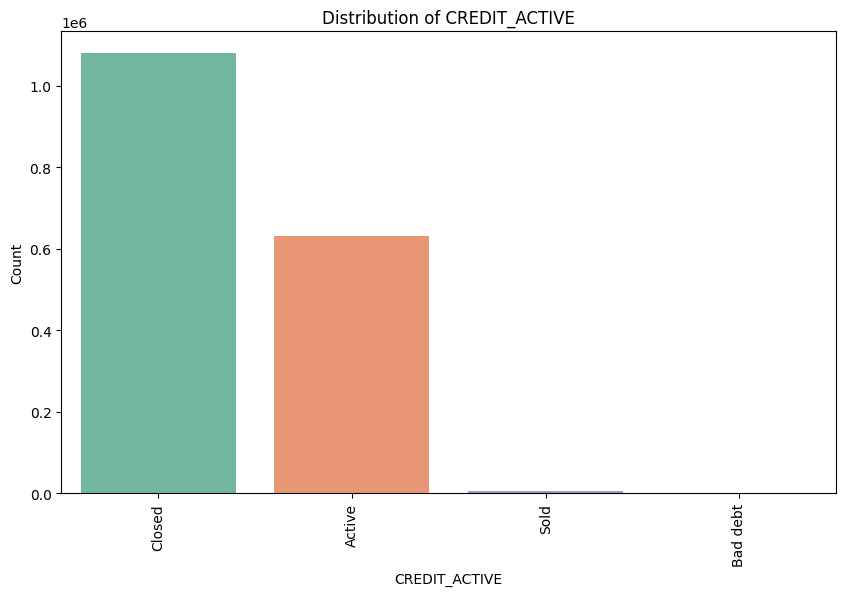


Analyzing feature: CREDIT_TYPE in Bureau Balance dataset


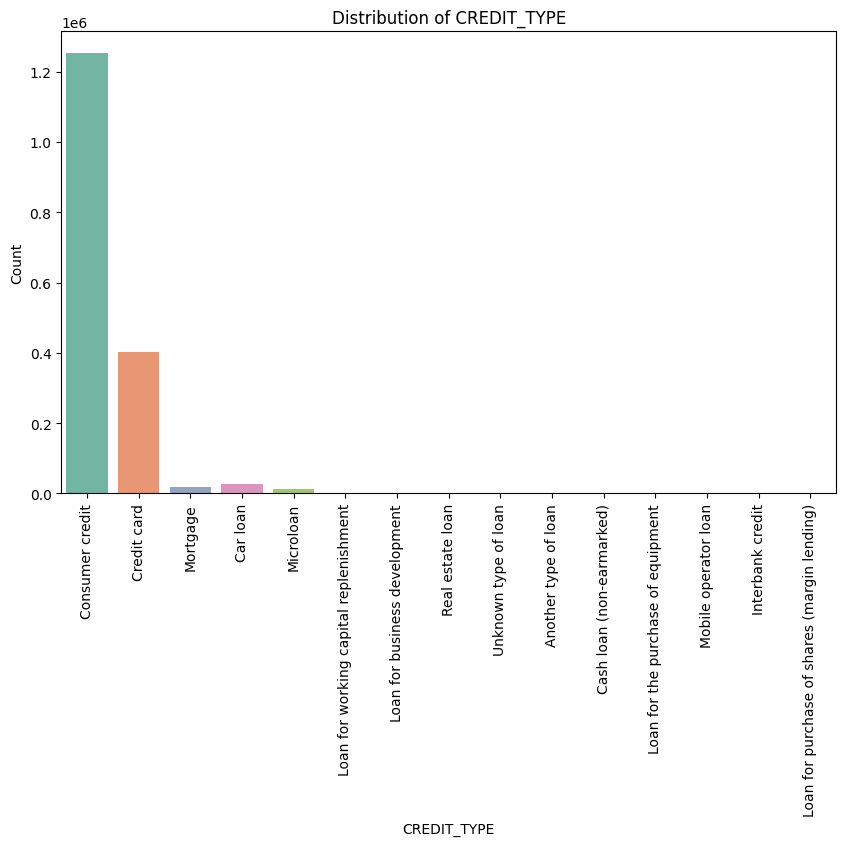


Analyzing feature: DAYS_CREDIT in Bureau Balance dataset


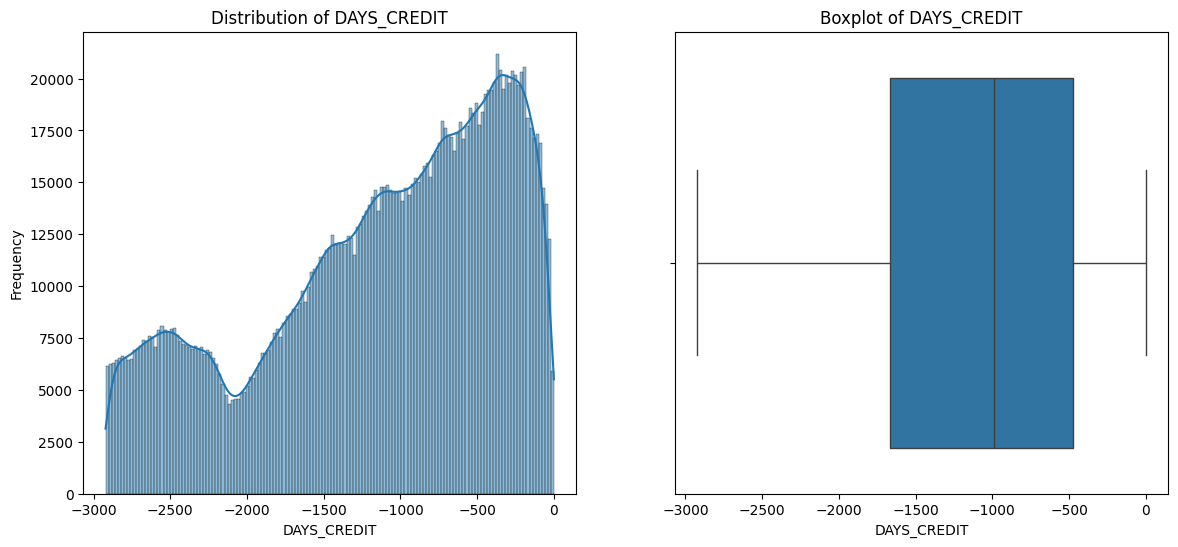


Analyzing feature: AMT_CREDIT_SUM in Bureau Balance dataset


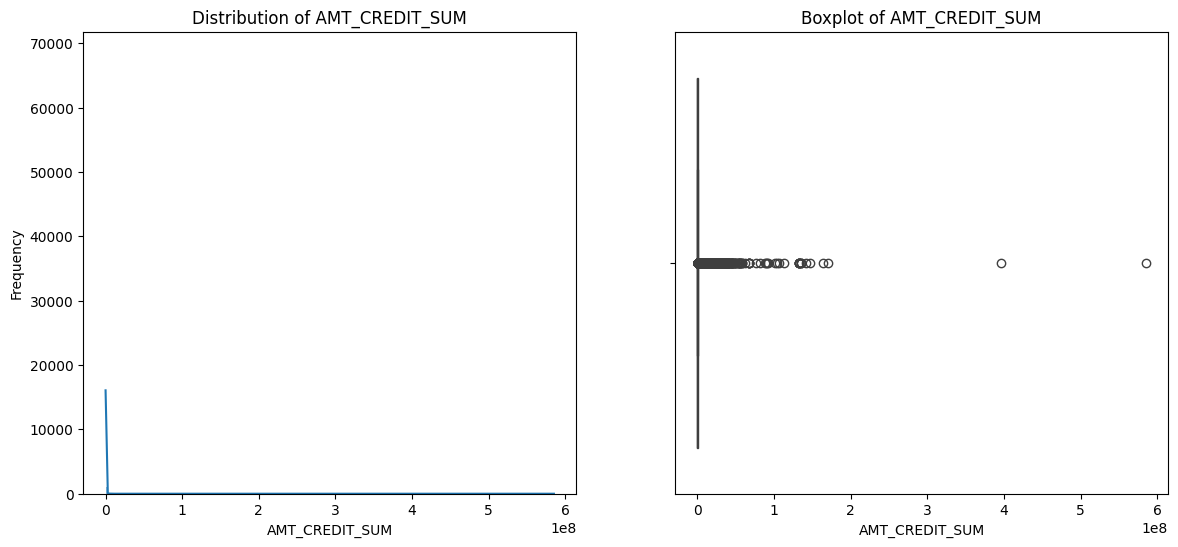

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt


def plot_categorical_distribution(df, feature):
    """
    This function plots the distribution of a categorical feature.

    Parameters:
    - df: pandas DataFrame containing the data.
    - feature: str, the name of the categorical feature column.
    """
    plt.figure(figsize=(10, 6))

    # Barplot
    sns.countplot(data=df, x=feature, palette='Set2')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

    # Rotate x-axis labels
    plt.xticks(rotation=90)

    plt.show()


def plot_univariate_analysis(df, feature):
    """
    This function plots the distribution of a numerical feature.

    Parameters:
    - df: pandas DataFrame containing the data.
    - feature: str, the name of the numerical feature column.
    """
    plt.figure(figsize=(14, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True, palette='Set2')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')

    plt.show()


# Analyse des variables catégorielles dans 'bureau'
categorical_features_bureau = ['CREDIT_ACTIVE', 'CREDIT_TYPE']

for feature in categorical_features_bureau:
    print(f"\nAnalyzing feature: {feature} in Bureau Balance dataset")
    plot_categorical_distribution(bureau_df, feature)


# Analyse univariée pour les colonnes numériques de 'bureau_balance'
numerical_features_bureau = ['DAYS_CREDIT', 'AMT_CREDIT_SUM']

for feature in numerical_features_bureau:
    print(f"\nAnalyzing feature: {feature} in Bureau Balance dataset")
    plot_univariate_analysis(bureau_df, feature)

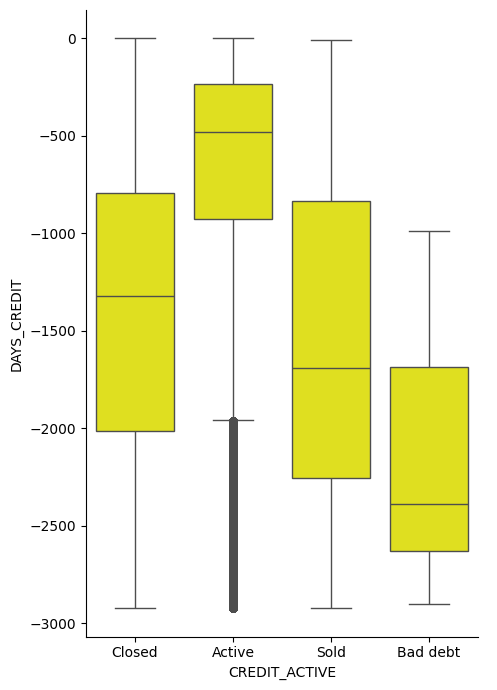

In [17]:
sns.catplot(x="CREDIT_ACTIVE", y="DAYS_CREDIT", data=bureau_df, color="yellow", kind="box", height=7, aspect=0.7);

In [18]:
bureau_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int32  
 1   SK_ID_BUREAU            int32  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int16  
 5   CREDIT_DAY_OVERDUE      int16  
 6   DAYS_CREDIT_ENDDATE     float16
 7   DAYS_ENDDATE_FACT       float16
 8   AMT_CREDIT_MAX_OVERDUE  float32
 9   CNT_CREDIT_PROLONG      int8   
 10  AMT_CREDIT_SUM          float32
 11  AMT_CREDIT_SUM_DEBT     float32
 12  AMT_CREDIT_SUM_LIMIT    float32
 13  AMT_CREDIT_SUM_OVERDUE  float32
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int32  
 16  AMT_ANNUITY             float32
dtypes: float16(2), float32(6), int16(2), int32(3), int8(1), object(3)
memory usage: 112.9+ MB


#EDA on the ‘Previous Application’ Dataset

In [19]:
# Chargement des datasets
previous_application_df = dataframes['previous_application.csv']

# Afficher les premières lignes pour examiner le contenu
print("Previous Application Dataset:")
previous_application_df.head()

Previous Application Dataset:


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
previous_application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int32  
 1   SK_ID_CURR                   1670214 non-null  int32  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float32
 4   AMT_APPLICATION              1670214 non-null  float32
 5   AMT_CREDIT                   1670213 non-null  float32
 6   AMT_DOWN_PAYMENT             774370 non-null   float32
 7   AMT_GOODS_PRICE              1284699 non-null  float32
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int8   
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int8   
 12  RATE_DOWN_PAYMENT            774370 non-nu


Analyzing feature: PURPOSE in Previous Application dataset


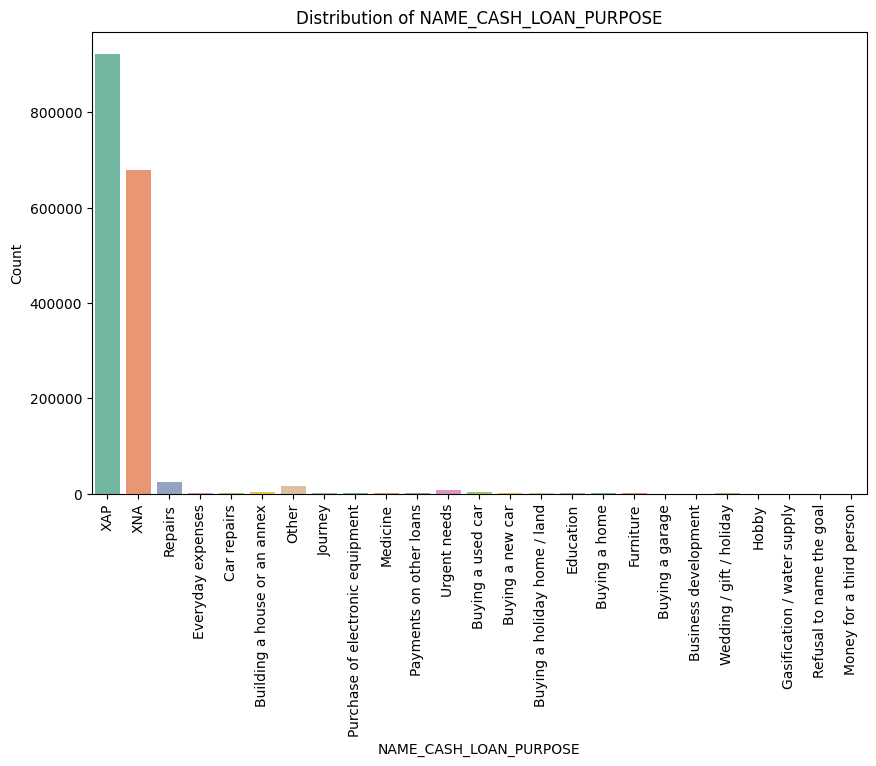

In [21]:
# Analyse de la variable PURPOSE
print("\nAnalyzing feature: PURPOSE in Previous Application dataset")
plot_categorical_distribution(previous_application_df, 'NAME_CASH_LOAN_PURPOSE')


Analyzing feature: NAME_CONTRACT_STATUS in Previous Application dataset


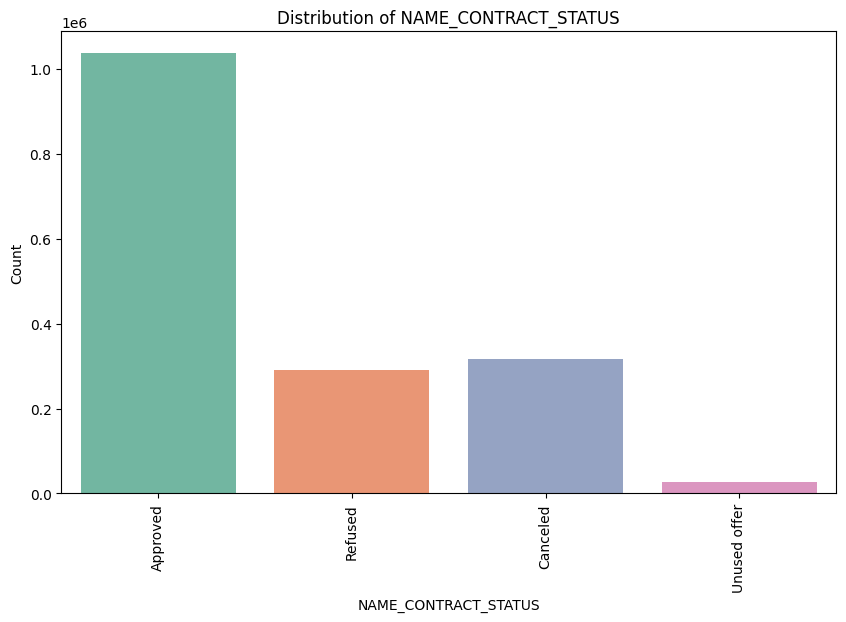

In [22]:
# Analyse de la variable NAME_CONTRACT_STATUS
print("\nAnalyzing feature: NAME_CONTRACT_STATUS in Previous Application dataset")
plot_categorical_distribution(previous_application_df, 'NAME_CONTRACT_STATUS')


Analyzing feature: NAME_CLIENT_TYPE in Previous Application dataset


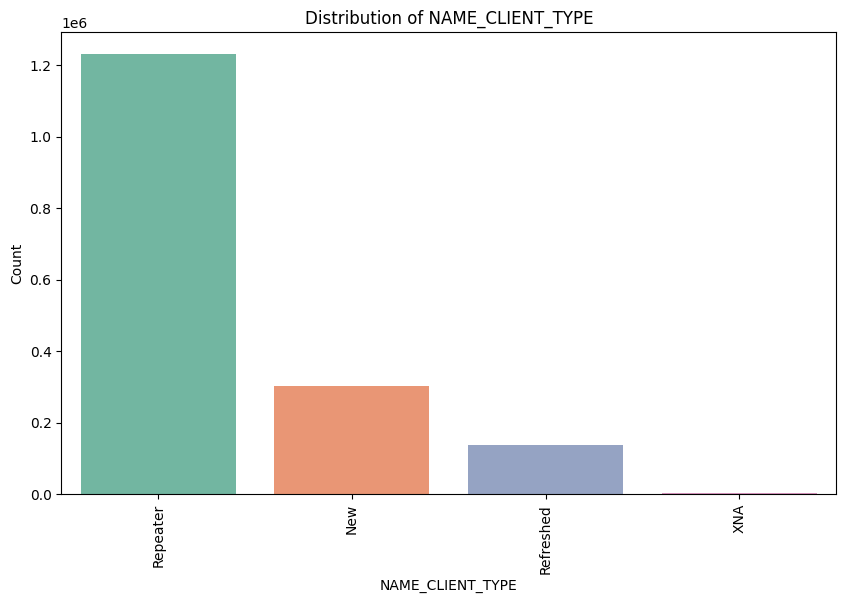

In [23]:
# Analyse de la variable NAME_CLIENT_TYPE
print("\nAnalyzing feature: NAME_CLIENT_TYPE in Previous Application dataset")
plot_categorical_distribution(previous_application_df, 'NAME_CLIENT_TYPE')

In [24]:
previous_application_df['DAYS_FIRST_DRAWING'].replace(
    max(previous_application_df['DAYS_FIRST_DRAWING'].values), np.nan, inplace=True
)

previous_application_df['DAYS_FIRST_DUE'].replace(np.nan, 0, inplace=True)
previous_application_df['DAYS_FIRST_DUE'].replace(0, np.nan, inplace=True)
previous_application_df['DAYS_FIRST_DUE'].replace(
    max(previous_application_df['DAYS_FIRST_DUE'].values), np.nan, inplace=True
)

previous_application_df['DAYS_LAST_DUE_1ST_VERSION'].replace(np.nan, 0, inplace=True)
previous_application_df['DAYS_LAST_DUE_1ST_VERSION'].replace(0, np.nan, inplace=True)
previous_application_df['DAYS_LAST_DUE_1ST_VERSION'].replace(
    max(previous_application_df['DAYS_LAST_DUE_1ST_VERSION'].values), np.nan, inplace=True
)

previous_application_df['DAYS_LAST_DUE'].replace(np.nan, 0, inplace=True)
previous_application_df['DAYS_LAST_DUE'].replace(0, np.nan, inplace=True)
previous_application_df['DAYS_LAST_DUE'].replace(
    max(previous_application_df['DAYS_LAST_DUE'].values), np.nan, inplace=True
)

previous_application_df['DAYS_TERMINATION'].replace(np.nan, 0, inplace=True)
previous_application_df['DAYS_TERMINATION'].replace(0, np.nan, inplace=True)
previous_application_df['DAYS_TERMINATION'].replace(
    max(previous_application_df['DAYS_TERMINATION'].values), np.nan, inplace=True
)

In [25]:
previous_application_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int32  
 1   SK_ID_CURR                   1670214 non-null  int32  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float32
 4   AMT_APPLICATION              1670214 non-null  float32
 5   AMT_CREDIT                   1670213 non-null  float32
 6   AMT_DOWN_PAYMENT             774370 non-null   float32
 7   AMT_GOODS_PRICE              1284699 non-null  float32
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int8   
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int8   
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [26]:
# Sauvegarde du DataFrame train_data en format CSV
previous_application_df.to_csv(cleaned_data_directory + 'previous_application.csv', index=False)

#EDA on the ‘POS Cash Balance’ Dataset

In [27]:
# Charger le dataset POS Cash Balance
pos_cash_balance_df = dataframes['POS_CASH_balance.csv']

# Afficher les premières lignes pour examiner le contenu
print("POS Cash Balance Dataset:")
pos_cash_balance_df.head()

POS Cash Balance Dataset:


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [28]:
pos_cash_balance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int32  
 1   SK_ID_CURR             int32  
 2   MONTHS_BALANCE         int8   
 3   CNT_INSTALMENT         float16
 4   CNT_INSTALMENT_FUTURE  float16
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int16  
 7   SK_DPD_DEF             int16  
dtypes: float16(2), int16(2), int32(2), int8(1), object(1)
memory usage: 238.5+ MB



Visualizing the distribution of Months Balance in POS Cash Balance dataset


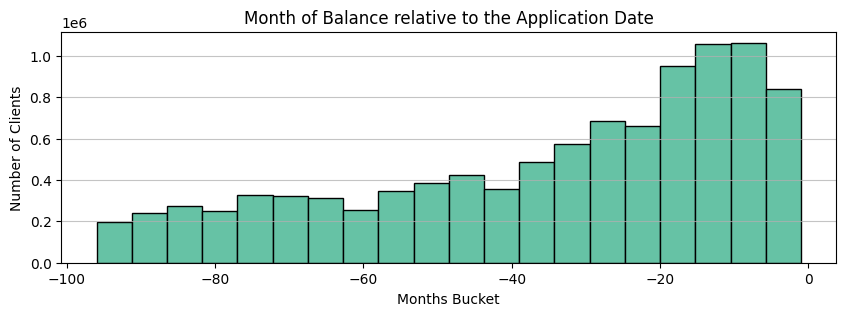

In [29]:
def plot_month_balance_histogram(df):
    """
    This function plots a histogram of balance months relative to the application date.

    Parameters:
    - df: pandas DataFrame containing the data.
    """
    plt.figure(figsize=(10, 3))
    plt.hist(df['MONTHS_BALANCE'].values, bins=20, edgecolor='black', color=sns.color_palette('Set2')[0])
    plt.title('Month of Balance relative to the Application Date')
    plt.xlabel('Months Bucket')
    plt.ylabel('Number of Clients')
    plt.grid(axis='y', alpha=0.75)
    plt.show()


# Visualiser la distribution des mois de balance
print("\nVisualizing the distribution of Months Balance in POS Cash Balance dataset")
plot_month_balance_histogram(pos_cash_balance_df)


Visualizing the distribution of Number of Installments in Future Credit in POS Cash Balance dataset


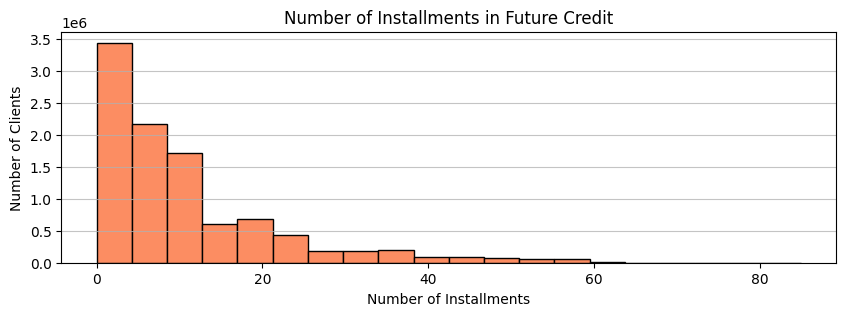

In [30]:
def plot_installment_histogram(df):
    """
    This function plots a histogram of the number of installments in the previous credit.

    Parameters:
    - df: pandas DataFrame containing the data.
    """
    plt.figure(figsize=(10, 3))
    plt.hist(df['CNT_INSTALMENT_FUTURE'].values, bins=20, edgecolor='black', color=sns.color_palette('Set2')[1])
    plt.title('Number of Installments in Future Credit')
    plt.xlabel('Number of Installments')
    plt.ylabel('Number of Clients')
    plt.grid(axis='y', alpha=0.75)
    plt.show()


# Visualiser la distribution du nombre de versements
print("\nVisualizing the distribution of Number of Installments in Future Credit in POS Cash Balance dataset")
plot_installment_histogram(pos_cash_balance_df)

#EDA on the ‘Installments Payments’ Dataset

In [31]:
# Charger le dataset Installments Payments
installments_payments_df = dataframes['installments_payments.csv']

# Afficher les premières lignes pour examiner le contenu
print("Installments Payments Dataset:")
installments_payments_df.head()

Installments Payments Dataset:


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [32]:
installments_payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int32  
 1   SK_ID_CURR              int32  
 2   NUM_INSTALMENT_VERSION  float16
 3   NUM_INSTALMENT_NUMBER   int16  
 4   DAYS_INSTALMENT         float16
 5   DAYS_ENTRY_PAYMENT      float16
 6   AMT_INSTALMENT          float32
 7   AMT_PAYMENT             float32
dtypes: float16(3), float32(2), int16(1), int32(2)
memory usage: 311.4 MB



Visualizing the distribution of Payment Amounts in Installments Payments dataset


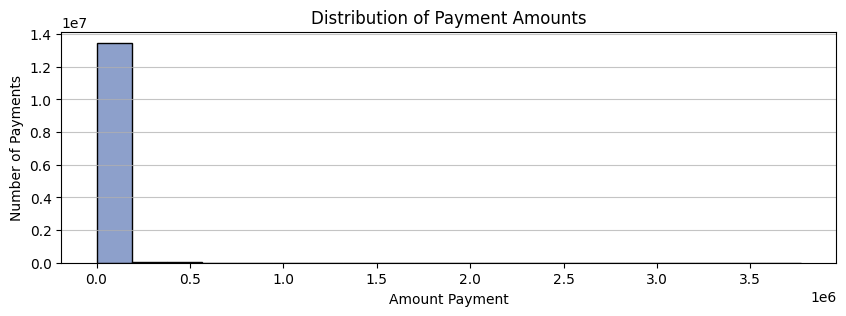

In [33]:
def plot_payment_amount_histogram(df):
    """
    This function plots a histogram of payment amounts.

    Parameters:
    - df: pandas DataFrame containing the data.
    """
    plt.figure(figsize=(10, 3))
    plt.hist(df['AMT_PAYMENT'].values, bins=20, edgecolor='black', color=sns.color_palette('Set2')[2])
    plt.title('Distribution of Payment Amounts')
    plt.xlabel('Amount Payment')
    plt.ylabel('Number of Payments')
    plt.grid(axis='y', alpha=0.75)
    plt.show()


# Visualiser la distribution des montants des paiements
print("\nVisualizing the distribution of Payment Amounts in Installments Payments dataset")
plot_payment_amount_histogram(installments_payments_df)


Visualizing the distribution of Installment Count in Installments Payments dataset


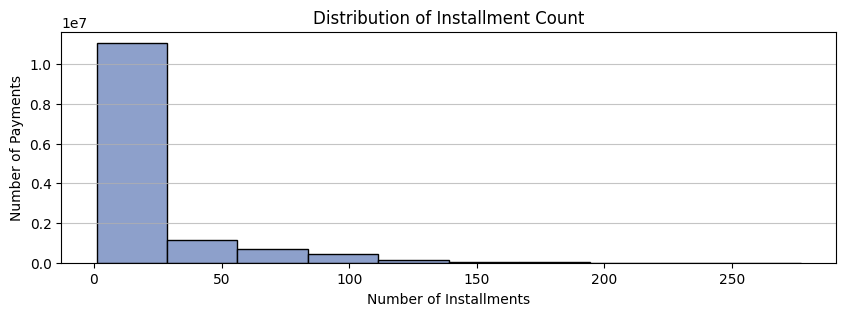

In [34]:
def plot_installment_count_histogram(df):
    """
    This function plots a histogram of the number of installments.

    Parameters:
    - df: pandas DataFrame containing the data.
    """
    plt.figure(figsize=(10, 3))
    plt.hist(df['NUM_INSTALMENT_NUMBER'].values, bins=10, edgecolor='black', color=sns.color_palette('Set2')[2])
    plt.title('Distribution of Installment Count')
    plt.xlabel('Number of Installments')
    plt.ylabel('Number of Payments')
    plt.grid(axis='y', alpha=0.75)
    plt.show()


# Visualiser la distribution du nombre d'installments
print("\nVisualizing the distribution of Installment Count in Installments Payments dataset")
plot_installment_count_histogram(installments_payments_df)

#EDA on the ‘Credit Card Balance’ Dataset

In [35]:
# Charger le dataset Credit Card Balance
credit_card_balance_df = dataframes['credit_card_balance.csv']

# Afficher les premières lignes pour examiner le contenu
print("Credit Card Balance Dataset:")
credit_card_balance_df.head()

Credit Card Balance Dataset:


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [36]:
credit_card_balance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int32  
 1   SK_ID_CURR                  int32  
 2   MONTHS_BALANCE              int8   
 3   AMT_BALANCE                 float32
 4   AMT_CREDIT_LIMIT_ACTUAL     int32  
 5   AMT_DRAWINGS_ATM_CURRENT    float32
 6   AMT_DRAWINGS_CURRENT        float32
 7   AMT_DRAWINGS_OTHER_CURRENT  float32
 8   AMT_DRAWINGS_POS_CURRENT    float32
 9   AMT_INST_MIN_REGULARITY     float32
 10  AMT_PAYMENT_CURRENT         float32
 11  AMT_PAYMENT_TOTAL_CURRENT   float32
 12  AMT_RECEIVABLE_PRINCIPAL    float32
 13  AMT_RECIVABLE               float32
 14  AMT_TOTAL_RECEIVABLE        float32
 15  CNT_DRAWINGS_ATM_CURRENT    float16
 16  CNT_DRAWINGS_CURRENT        int16  
 17  CNT_DRAWINGS_OTHER_CURRENT  float16
 18  CNT_DRAWINGS_POS_CURRENT    float16
 19  CNT_INSTALMENT_MATURE


Visualizing the distribution of Months_Balance in Credit Card Balance dataset


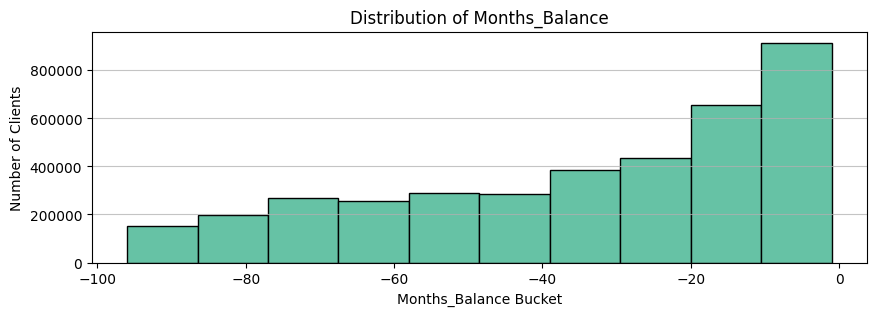

In [37]:
def plot_month_balance_histogram(df):
    """
    This function plots a histogram of months balance.

    Parameters:
    - df: pandas DataFrame containing the data.
    """
    plt.figure(figsize=(10, 3))
    plt.hist(df['MONTHS_BALANCE'].values, bins=10, edgecolor='black', color=sns.color_palette('Set2')[0])
    plt.title('Distribution of Months_Balance')
    plt.xlabel('Months_Balance Bucket')
    plt.ylabel('Number of Clients')
    plt.grid(axis='y', alpha=0.75)
    plt.show()


# Visualiser la distribution des mois de balance
print("\nVisualizing the distribution of Months_Balance in Credit Card Balance dataset")
plot_month_balance_histogram(credit_card_balance_df)


Visualizing the boxplot of Cumulative Number of Matured Installments in Credit Card Balance dataset


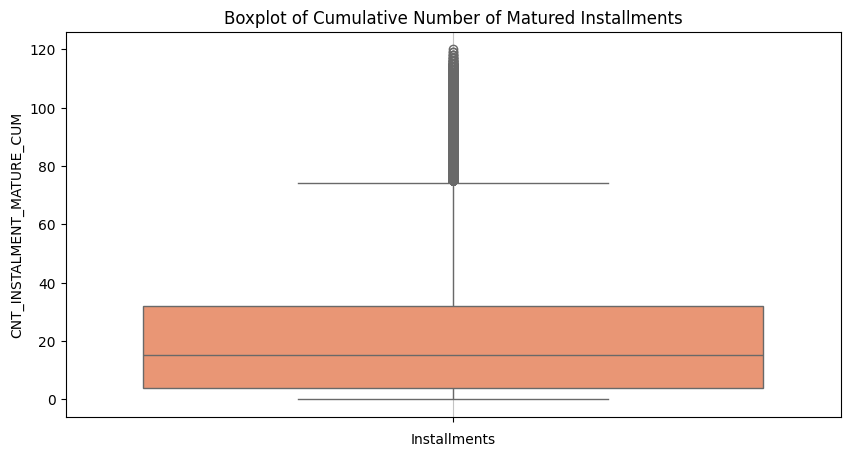

In [38]:
def plot_installment_mature_boxplot(df):
    """
    This function plots a boxplot for the cumulative number of matured installments.

    Parameters:
    - df: pandas DataFrame containing the data.
    """
    plt.figure(figsize=(10, 5))
    sns.boxplot(y='CNT_INSTALMENT_MATURE_CUM', data=df, color=sns.color_palette('Set2')[1])
    plt.title('Boxplot of Cumulative Number of Matured Installments')
    plt.xlabel('Installments')
    plt.grid(axis='x', alpha=0.75)
    plt.show()


# Visualiser le boxplot des installments matures cumulatifs
print("\nVisualizing the boxplot of Cumulative Number of Matured Installments in Credit Card Balance dataset")
plot_installment_mature_boxplot(credit_card_balance_df)